<a href="https://colab.research.google.com/github/xxxcrttt/0022-Dissertation/blob/main/training%20process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import requests

API_KEY = 'ei_fa0509c4c0d12e026934b03bb2f56c4c75771e18fb403be6bcb4b30ebdc27435'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/112844/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/112844/training/5/y')



In [ ]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

In [ ]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "0", "1", "2", "3", "4", "5", "6", "7" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


In [ ]:
import math
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization, Conv2D, GlobalMaxPooling2D, Lambda
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.losses import categorical_crossentropy



In [ ]:
WEIGHTS_PATH = './transfer-learning-weights/keras/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5'
# Download the model weights
root_url = 'http://cdn.edgeimpulse.com/'
p = Path(WEIGHTS_PATH)
if not p.exists():
    if not p.parent.exists():
        p.parent.mkdir(parents=True)
    weights = requests.get(root_url + WEIGHTS_PATH[2:]).content
    with open(WEIGHTS_PATH, 'wb') as f:
        f.write(weights)

INPUT_SHAPE = (160, 160, 3)


base_model = tf.keras.applications.MobileNetV2(
    input_shape = INPUT_SHAPE, alpha=1,
    weights = WEIGHTS_PATH
)

base_model.trainable = False

model = Sequential()
model.add(InputLayer(input_shape=INPUT_SHAPE, name='x_input'))
# Don't include the base model's top layers
last_layer_index = -3
model.add(Model(inputs=base_model.inputs, outputs=base_model.layers[last_layer_index].output))
model.add(Reshape((-1, model.layers[-1].output.shape[3])))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

# Set the data to the expected input shape
train_dataset = train_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)


BATCH_SIZE = 32
EPOCHS = 30
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history1 = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, verbose=2, callbacks=callbacks)

print('')
print('Initial training done.', flush=True)



Epoch 1/20
37/37 - 28s - loss: 2.6671 - accuracy: 0.1926 - val_loss: 1.7683 - val_accuracy: 0.4061 - 28s/epoch - 764ms/step
Epoch 2/20
37/37 - 20s - loss: 1.2910 - accuracy: 0.5283 - val_loss: 1.0526 - val_accuracy: 0.5870 - 20s/epoch - 531ms/step
Epoch 3/20
37/37 - 22s - loss: 0.8706 - accuracy: 0.6610 - val_loss: 0.7618 - val_accuracy: 0.7270 - 22s/epoch - 583ms/step
Epoch 4/20
37/37 - 21s - loss: 0.6616 - accuracy: 0.7611 - val_loss: 0.6128 - val_accuracy: 0.7782 - 21s/epoch - 564ms/step
Epoch 5/20
37/37 - 21s - loss: 0.5408 - accuracy: 0.8116 - val_loss: 0.5135 - val_accuracy: 0.8157 - 21s/epoch - 575ms/step
Epoch 6/20
37/37 - 20s - loss: 0.4604 - accuracy: 0.8322 - val_loss: 0.4480 - val_accuracy: 0.8430 - 20s/epoch - 530ms/step
Epoch 7/20
37/37 - 20s - loss: 0.3996 - accuracy: 0.8545 - val_loss: 0.3983 - val_accuracy: 0.8635 - 20s/epoch - 547ms/step
Epoch 8/20
37/37 - 20s - loss: 0.3621 - accuracy: 0.8793 - val_loss: 0.3614 - val_accuracy: 0.8771 - 20s/epoch - 528ms/step
Epoch 9/

In [ ]:
%matplotlib inline 

# import matplotlib libaray
import matplotlib.pyplot as plt

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 5, 5, 1280)        2257984   
                                                                 
 reshape (Reshape)           (None, 25, 1280)          0         
                                                                 
 dropout (Dropout)           (None, 25, 1280)          0         
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 8)                 256008    
                                                                 
Total params: 2,513,992
Trainable params: 256,008
Non-trainable params: 2,257,984
_________________________________________________________________


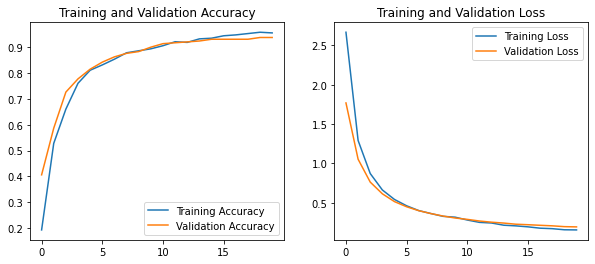

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# How many epochs we will fine tune the model
FINE_TUNE_EPOCHS = 10
# What percentage of the base model's layers we will fine tune
FINE_TUNE_PERCENTAGE = 65

print('Fine-tuning model for {} epochs...'.format(FINE_TUNE_EPOCHS), flush=True)

# Determine which layer to begin fine tuning at
model_layer_count = len(model.layers)
fine_tune_from = math.ceil(model_layer_count * ((100 - FINE_TUNE_PERCENTAGE) / 100))

# Allow the entire base model to be trained
model.trainable = True
# Freeze all the layers before the 'fine_tune_from' layer
for layer in model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000045),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_dataset,
                epochs=FINE_TUNE_EPOCHS,
                verbose=2,
                validation_data=validation_dataset,
                callbacks=callbacks,
                class_weight=None
            )



Fine-tuning model for 10 epochs...
Epoch 1/10
37/37 - 24s - loss: 0.1670 - accuracy: 0.9503 - val_loss: 0.1548 - val_accuracy: 0.9590 - 24s/epoch - 637ms/step
Epoch 2/10
37/37 - 20s - loss: 0.1047 - accuracy: 0.9683 - val_loss: 0.1366 - val_accuracy: 0.9625 - 20s/epoch - 545ms/step
Epoch 3/10
37/37 - 20s - loss: 0.0890 - accuracy: 0.9709 - val_loss: 0.1244 - val_accuracy: 0.9625 - 20s/epoch - 544ms/step
Epoch 4/10
37/37 - 20s - loss: 0.0681 - accuracy: 0.9846 - val_loss: 0.1161 - val_accuracy: 0.9761 - 20s/epoch - 547ms/step
Epoch 5/10
37/37 - 20s - loss: 0.0505 - accuracy: 0.9906 - val_loss: 0.1130 - val_accuracy: 0.9693 - 20s/epoch - 545ms/step
Epoch 6/10
37/37 - 20s - loss: 0.0423 - accuracy: 0.9940 - val_loss: 0.1109 - val_accuracy: 0.9693 - 20s/epoch - 549ms/step
Epoch 7/10
37/37 - 20s - loss: 0.0391 - accuracy: 0.9906 - val_loss: 0.1103 - val_accuracy: 0.9693 - 20s/epoch - 541ms/step
Epoch 8/10
37/37 - 20s - loss: 0.0355 - accuracy: 0.9957 - val_loss: 0.1086 - val_accuracy: 0.979